### Check univariate profile for subject 2

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nibabel.freesurfer.io import read_label
from sklearn.feature_selection import f_classif
from palettable.matplotlib import Inferno_3 as ColMap
from fmri_tools.io.surf import read_mgh, write_label
from fmri_decoder.data import SurfaceData
from src.data import Data
from src.config import SESSION, N_LAYER
plt.style.use(os.path.join(module_path, "src", "default.mplstyle"))

DIR_DATA = "/data/pt_01880/Experiment1_ODC/paper/decoding"
FILTER_SIZE = "none"

# set
SUBJECT = "p2"
SESS = "GE_EPI" # GE_EPI, SE_EPI, VASO, VASO_uncorrected
METRIC = "psc"
NMAX = 200  # int | NoneNone
USE_MARIANNA = False  # use mariannas labels

In [2]:
def get_label(subj):
    # get label and hemisphere
    data = Data(subj, [])
    surf_data = SurfaceData(data.file_layer, None, data.file_label)

    label_left = surf_data.load_label_intersection("lh")
    label_right = surf_data.load_label_intersection("rh")

    hemi = np.zeros(len(label_left)+len(label_right))
    hemi[len(label_left):] = 1
    label = np.append(label_left, label_right)

    return label, hemi

def select_features(dtf, label, hemi):
    # choose subset of features
    features = dtf.columns[2:]
    
    X = np.array(dtf.loc[:, features])
    y = np.array(dtf.loc[:, "label"])

    f_statistic = f_classif(X, y)[0]
    index = np.arange(len(features))
    index_sorted = np.array(
                [x for _, x in sorted(zip(f_statistic, index), reverse=True)]
            )
    index_sorted = index_sorted[: NMAX]

    label_selected = label[index_sorted]
    hemi_selected = hemi[index_sorted]

    return label_selected, hemi_selected

def get_profile(subj, sess, day, use_marianna=True):
    # get data profiles
    y = np.zeros(N_LAYER)
    label, hemi = get_label(subj)
    for j in range(N_LAYER):
        if sess.endswith("_uncorrected"):
            data = Data(subj, f"{sess.replace('_uncorrected', '')}{SESSION[subj][sess][day]}_uncorrected")
            data2 = Data(subj, f"{sess.replace('_uncorrected', '')}{SESSION[subj][sess][day]}")
            dtf = pd.read_parquet(data2.get_sample_data(j))
        else:
            data = Data(subj, f"{sess}{SESSION[subj][sess][day]}")
            dtf = pd.read_parquet(data.get_sample_data(j))
        if NMAX:
            label_selected, hemi_selected = select_features(dtf, label, hemi)
        else:
            label_selected = label
            hemi_selected = hemi

        if METRIC == "tsnr":
            arr_left = data.get_tsnr("lh", j)
            arr_right = data.get_tsnr("rh", j)
        elif METRIC == "cnr":
            arr_left = data.get_cnr("lh", j)
            arr_right = data.get_cnr("rh", j)
        elif METRIC == "psc":
            arr_left = data.get_psc("lh", j)
            arr_right = data.get_psc("rh", j)
        elif METRIC == "rest":
            arr_left = data.get_rest("lh", j)
            arr_right = data.get_rest("rh", j)
        else:
            ValueError("Unknown metric!")

        if use_marianna:
            # use mariannas labels
            label_left = read_label("./label_marianna/lh_max200_vertices.label")
            label_right = read_label("./label_marianna/rh_max200_vertices.label")
        else:
            # use my labels and save as label files
            label_left = label_selected[hemi_selected==0]
            label_right = label_selected[hemi_selected==1]
            write_label(f"./label_daniel/lh.subj2_session_{SESSION[subj][sess][day]}_layer_{j}.label", label_selected[hemi_selected==0])
            write_label(f"./label_daniel/rh.subj2_session_{SESSION[subj][sess][day]}_layer_{j}.label", label_selected[hemi_selected==1])
        
        tmp = np.concatenate((arr_left[label_left], arr_right[label_right]), axis=0)
        y[j] = np.mean(tmp)
    return y

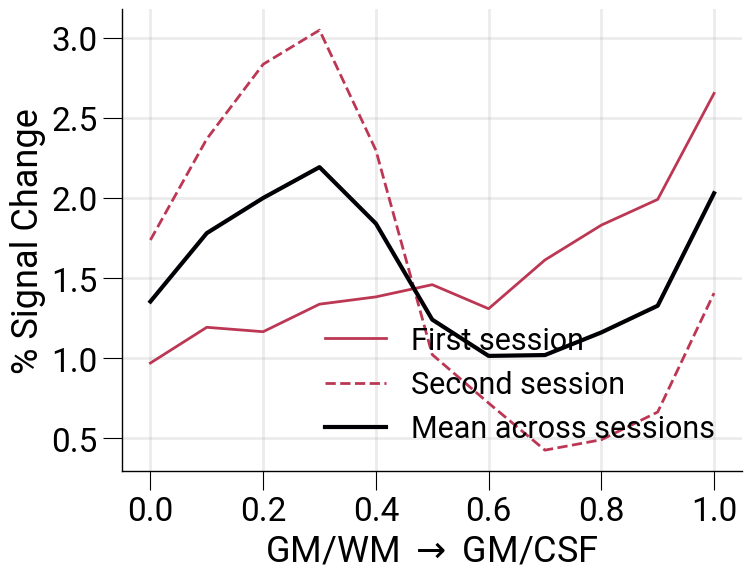

In [3]:
x = np.linspace(0, 1, N_LAYER)
y1 = get_profile(SUBJECT, SESS, 0, USE_MARIANNA)
y2 = get_profile(SUBJECT, SESS, 1, USE_MARIANNA)
y3 = np.append(y1, y2)
if SESS == "VASO":
    y1 *= -1
    y2 *= -1
    y3 *= -1

fig, ax = plt.subplots()
color = ColMap.hex_colors
ax.plot(x, y1, color=color[1], linestyle="-", label="First session")
ax.plot(x, y2, color=color[1], linestyle="--", label="Second session")
ax.plot(x, (y1+y2)/2, color=color[0], linestyle="-", label="Mean across sessions", lw=3)
ax.set_xlabel(r"GM/WM $\rightarrow$ GM/CSF")
if SESS == "VASO":
    ax.set_ylabel("Negative % Signal Change")
else:
    ax.set_ylabel("% Signal Change")
ax.legend(loc="lower right")